In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-04-02 02:13:01.231870: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
labels = labels.astype(np.float64)

In [6]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually

In [7]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [8]:
import json

In [9]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [10]:
X_train = images[0:image_data['39']] 
y_train = labels[0:label_data['39']]
X_val = images[image_data['84']:]
y_val = labels[label_data['84']:]

In [11]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    dropout_change_per_layer=0.0,
    num_layers=4,
    output_activation='sigmoid')

2023-04-02 02:13:04.716127: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-02 02:13:04.930172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-02 02:13:04.932778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-02 02:13:04.932796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-02 02:13:04.952477: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-02 

In [12]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [14]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=32, 
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-04-02 02:13:07.606369: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-02 02:13:07.625172: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-02 02:13:08.850537: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-02 02:13:09.677255: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-02 02:13:10.752828: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-02 02:13:10.752853: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-02 02:13:10.753207: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-02 02:13:10.840146: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-02 02:13:12.027914: I tensorflow/stream_exec

10/11 [==========================>...] - ETA: 0s - loss: 2.1694 - iou: 5.9852e-05 - iou_thresholded: 2.1854e-04

2023-04-02 02:13:45.705022: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-04-02 02:13:46.396679: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-04-02 02:13:46.397046: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


11/11 [==============================] - 55s 3s/step - loss: 2.0131 - iou: 5.7855e-05 - iou_thresholded: 2.1949e-04 - val_loss: 0.3647 - val_iou: 2.0602e-05 - val_iou_thresholded: 3.3159e-04
Epoch 2/200
11/11 [==============================] - 11s 1s/step - loss: 0.2278 - iou: 1.3039e-05 - iou_thresholded: 2.4161e-04 - val_loss: 0.0540 - val_iou: 3.7790e-06 - val_iou_thresholded: 3.3159e-04
Epoch 3/200
11/11 [==============================] - 11s 1s/step - loss: 0.0292 - iou: 3.1131e-05 - iou_thresholded: 2.3994e-04 - val_loss: 0.0197 - val_iou: 5.7178e-05 - val_iou_thresholded: 3.3159e-04
Epoch 4/200
11/11 [==============================] - 11s 1s/step - loss: 0.0137 - iou: 1.1128e-04 - iou_thresholded: 2.3913e-04 - val_loss: 0.0113 - val_iou: 1.8180e-04 - val_iou_thresholded: 3.3159e-04
Epoch 5/200
11/11 [==============================] - 11s 1s/step - loss: 0.0082 - iou: 1.5459e-04 - iou_thresholded: 2.4048e-04 - val_loss: 0.0079 - val_iou: 2.4254e-04 - val_iou_thresholded: 3.3159e-

11/11 [==============================] - 11s 1s/step - loss: 0.0050 - iou: 0.1264 - iou_thresholded: 0.1870 - val_loss: 0.0044 - val_iou: 0.0021 - val_iou_thresholded: 3.3159e-04
Epoch 44/200
11/11 [==============================] - 11s 1s/step - loss: 0.0038 - iou: 0.0021 - iou_thresholded: 2.4529e-04 - val_loss: 0.0046 - val_iou: 0.0037 - val_iou_thresholded: 3.3159e-04
Epoch 45/200
11/11 [==============================] - 11s 1s/step - loss: 0.0034 - iou: 0.0067 - iou_thresholded: 2.4163e-04 - val_loss: 0.0049 - val_iou: 0.0099 - val_iou_thresholded: 3.3159e-04
Epoch 46/200
11/11 [==============================] - 11s 1s/step - loss: 0.0030 - iou: 0.0129 - iou_thresholded: 2.8466e-04 - val_loss: 0.0040 - val_iou: 0.0226 - val_iou_thresholded: 7.4573e-04
Epoch 47/200
11/11 [==============================] - 11s 1s/step - loss: 0.0024 - iou: 0.0419 - iou_thresholded: 0.0111 - val_loss: 0.0034 - val_iou: 0.0572 - val_iou_thresholded: 0.0498
Epoch 48/200
11/11 [=========================

Epoch 86/200
11/11 [==============================] - 11s 1s/step - loss: 4.9552e-04 - iou: 0.4370 - iou_thresholded: 0.5873 - val_loss: 0.0063 - val_iou: 0.1580 - val_iou_thresholded: 0.2369
Epoch 87/200
11/11 [==============================] - 11s 1s/step - loss: 3.9626e-04 - iou: 0.4712 - iou_thresholded: 0.6099 - val_loss: 0.0063 - val_iou: 0.1148 - val_iou_thresholded: 0.1482
Epoch 88/200
11/11 [==============================] - 11s 1s/step - loss: 1.9759e-04 - iou: 0.5118 - iou_thresholded: 0.6340 - val_loss: 0.0063 - val_iou: 0.1354 - val_iou_thresholded: 0.1757
Epoch 89/200
11/11 [==============================] - 11s 1s/step - loss: 1.4679e-04 - iou: 0.5110 - iou_thresholded: 0.6301 - val_loss: 0.0077 - val_iou: 0.1882 - val_iou_thresholded: 0.2396
Epoch 90/200
11/11 [==============================] - 11s 1s/step - loss: -4.5009e-05 - iou: 0.5573 - iou_thresholded: 0.6572 - val_loss: 0.0100 - val_iou: 0.1149 - val_iou_thresholded: 0.1204
Epoch 91/200
11/11 [===================

11/11 [==============================] - 11s 1s/step - loss: 0.0118 - iou: 1.6593e-04 - iou_thresholded: 2.4248e-04 - val_loss: 0.0146 - val_iou: 1.9617e-04 - val_iou_thresholded: 3.3159e-04
Epoch 128/200
11/11 [==============================] - 11s 1s/step - loss: 0.0110 - iou: 1.5646e-04 - iou_thresholded: 2.4014e-04 - val_loss: 0.0136 - val_iou: 1.6922e-04 - val_iou_thresholded: 3.3159e-04
Epoch 129/200
11/11 [==============================] - 11s 1s/step - loss: 0.0103 - iou: 1.4934e-04 - iou_thresholded: 2.4660e-04 - val_loss: 0.0127 - val_iou: 1.6185e-04 - val_iou_thresholded: 3.3159e-04
Epoch 130/200
11/11 [==============================] - 11s 1s/step - loss: 0.0098 - iou: 1.5612e-04 - iou_thresholded: 2.4091e-04 - val_loss: 0.0119 - val_iou: 1.9518e-04 - val_iou_thresholded: 3.3159e-04
Epoch 131/200
11/11 [==============================] - 11s 1s/step - loss: 0.0089 - iou: 1.5977e-04 - iou_thresholded: 2.4281e-04 - val_loss: 0.0110 - val_iou: 1.9146e-04 - val_iou_thresholded: 

Epoch 168/200
11/11 [==============================] - 11s 1s/step - loss: 0.0035 - iou: 0.0029 - iou_thresholded: 2.4624e-04 - val_loss: 0.0044 - val_iou: 0.0027 - val_iou_thresholded: 3.3159e-04
Epoch 169/200
11/11 [==============================] - 11s 1s/step - loss: 0.0035 - iou: 0.0029 - iou_thresholded: 2.4581e-04 - val_loss: 0.0044 - val_iou: 0.0026 - val_iou_thresholded: 3.3159e-04
Epoch 170/200
11/11 [==============================] - 11s 1s/step - loss: 0.0035 - iou: 0.0029 - iou_thresholded: 2.4459e-04 - val_loss: 0.0044 - val_iou: 0.0026 - val_iou_thresholded: 3.3159e-04
Epoch 171/200
11/11 [==============================] - 11s 1s/step - loss: 0.0035 - iou: 0.0027 - iou_thresholded: 2.4653e-04 - val_loss: 0.0044 - val_iou: 0.0026 - val_iou_thresholded: 3.3159e-04
Epoch 172/200
11/11 [==============================] - 11s 1s/step - loss: 0.0035 - iou: 0.0029 - iou_thresholded: 2.4038e-04 - val_loss: 0.0044 - val_iou: 0.0027 - val_iou_thresholded: 3.3159e-04
Epoch 173/200
1

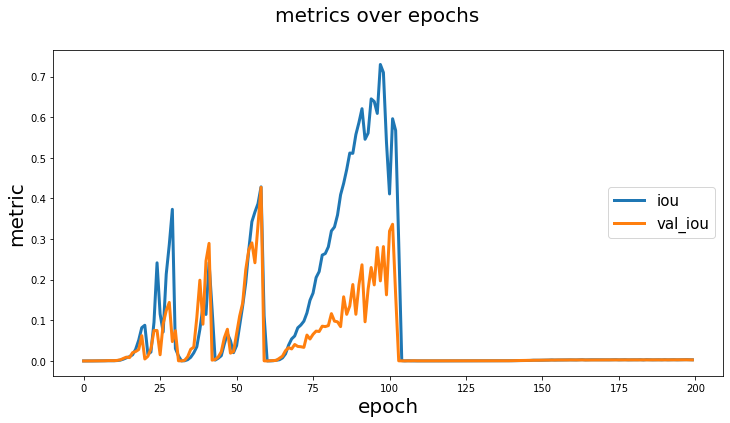

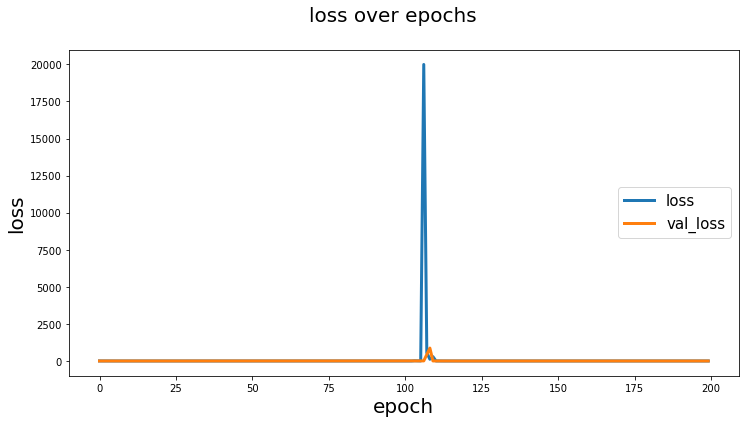

In [15]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [16]:
y_pred = model.predict(X_val)

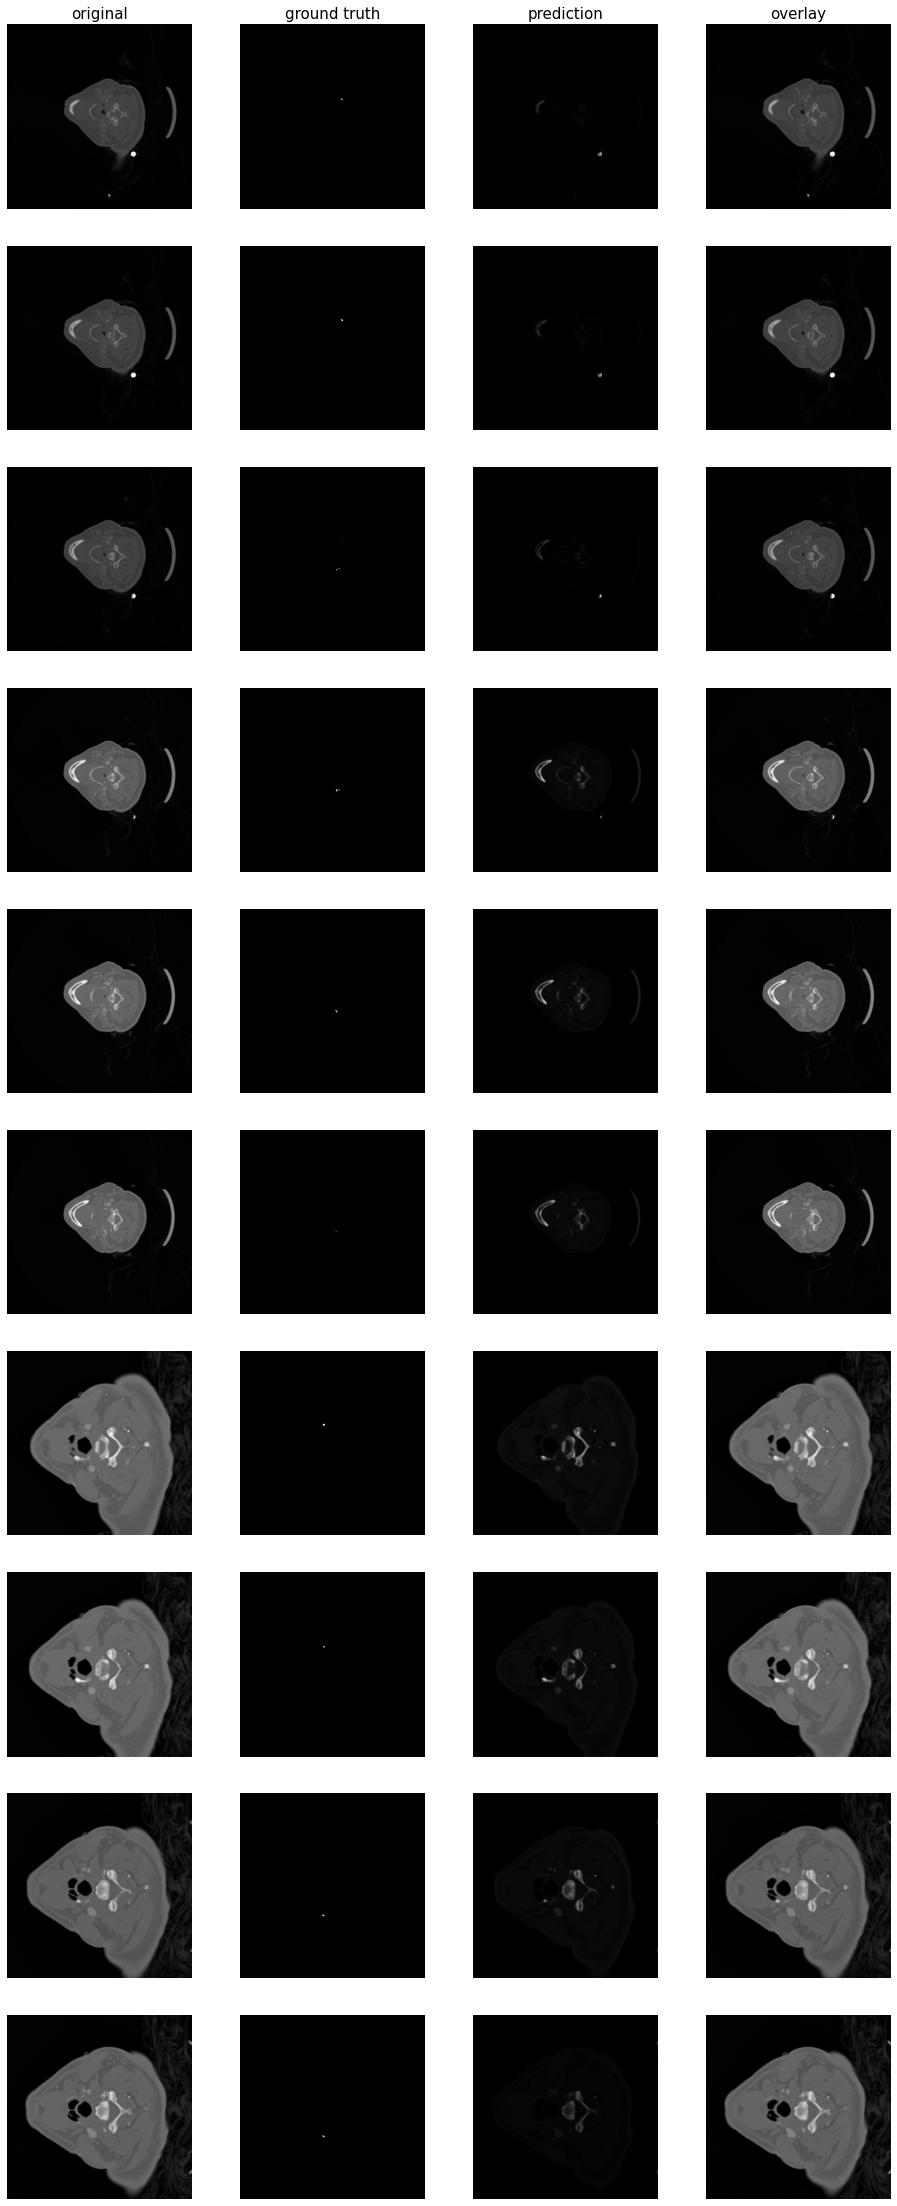

In [17]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [18]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 1s 194ms/step - loss: 0.0044 - iou: 0.0027 - iou_thresholded: 3.3159e-04
